In [2]:
import pandas as pd
import glob
import re
import numpy as np
from datetime import datetime
import gc
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
gc.collect()

0

### Load all patient list and isolate the test set

In [3]:
# Load the patient list from its CSV file
patient_list_path = "/mnt/d/pydatascience/g3_regress/data/pt_ls.csv"
test_list_path = "/mnt/d/pydatascience/g3_regress/data/test_ls.csv"
pt_ls = pd.read_csv(patient_list_path)
test_ls = pd.read_csv(test_list_path)

# Convert patient list dates to datetime
pt_ls['key'] = pt_ls['key'].astype(int)
pt_ls['first_sub_60_date'] = pd.to_datetime(pt_ls['first_sub_60_date'], errors='coerce')
pt_ls['first_sub_10_date'] = pd.to_datetime(pt_ls['first_sub_10_date'], errors='coerce')
test_ls['key'] = test_ls['key'].astype(int)
test_ls['first_sub_10_date'] = pd.to_datetime(test_ls['first_sub_10_date'], errors='coerce')
test_ls['first_sub_10_date'] = pd.to_datetime(test_ls['first_sub_10_date'], errors='coerce')

display(pt_ls.info())
display(pt_ls.head())
display(test_ls.info())
display(test_ls.head())

gc.collect()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37916 entries, 0 to 37915
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   key                37916 non-null  int64         
 1   first_sub_60_date  37916 non-null  datetime64[ns]
 2   first_sub_10_date  3614 non-null   datetime64[ns]
dtypes: datetime64[ns](2), int64(1)
memory usage: 888.8 KB


None

,key,first_sub_60_date,first_sub_10_date
0,449,2009-09-10 10:54:00,NaT
1,1722,2011-08-01 14:14:00,NaT
2,1874,2011-12-07 08:57:00,2013-05-29 09:51:00
3,2334,2009-07-22 09:41:00,NaT
4,2929,2010-09-30 09:57:00,NaT


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6066 entries, 0 to 6065
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   key                6066 non-null   int64         
 1   first_sub_60_date  6066 non-null   object        
 2   first_sub_10_date  239 non-null    datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 142.3+ KB


None

,key,first_sub_60_date,first_sub_10_date
0,3300,2023-12-19 09:24:00,NaT
1,4779,2022-06-22 12:08:00,NaT
2,10448,2019-12-20 10:10:00,NaT
3,15464,2022-07-05 10:41:00,NaT
4,19150,2020-04-20 08:54:00,NaT


0

### Creation of endpoint for all patients:
1. Merge the pt_ls with OT and Death record
2. create 2 new columns with name as 'first_endpoint_date', 'endpoint'
3. check the column of 'first_sub_10_date'	'ot_date'	'death_date':
    - if all 3 column have NaT only, the 'first_endpoint_date' will be 31/12/2023, 'endpoint' will be 0 (censored)
    - if only 1 date avaliable:
        - if the date is at 'first_sub_10_date', copy the date to the 'first_endpoint_date', 'endpoint' will be 1 (rrt)
        - if the date is at 'ot_date', copy the date to the 'first_endpoint_date', 'endpoint' will be 1 (rrt)
        - if the date is at 'death_date', copy the date to the 'first_endpoint_date', 'endpoint' will be 2 (death)
4. if more than 1 date avaliable in the 'first_sub_10_date'	'ot_date'	'death_date':
    - find out the location of the earliest date
    - if the earliest date is at 'first_sub_10_date', copy the date to the 'first_endpoint_date', 'endpoint' will be 1 (rrt)
    - if the earliest date is at 'ot_date', copy the date to the 'first_endpoint_date', 'endpoint' will be 1 (rrt)
    - if the earliest date is at 'death_date', copy the date to the 'first_endpoint_date', 'endpoint' will be 2 (death) 

In [4]:
ot_path = "/mnt/d/pydatascience/g3_regress/data/ot"
ot_files = glob.glob(f"{ot_path}/ot*.csv")
ot_dataframes = [pd.read_csv(file, skiprows=1, header=0) for file in ot_files]
ot_df = pd.concat(ot_dataframes, ignore_index=True)
ot_df.columns = ['key', 'ot_date', 'code',
                 'ot1', 'ot2', 'ot3', 'ot4', 'ot5',
                 'ot6', 'ot7', 'ot8', 'ot9', 'ot10',
                 'ot11', 'ot12', 'ot13', 'ot14', 'ot15',
                 'ot_desc1', 'ot_desc2', 'ot_desc3', 'ot_desc4', 'ot_desc5',
                 'ot_desc6', 'ot_desc7', 'ot_desc8', 'ot_desc9', 'ot_desc10',
                 'ot_desc11', 'ot_desc12', 'ot_desc13', 'ot_desc14', 'ot_desc15', 'episodes']
ot_df['key'] = ot_df['key'].astype(int)
ot_df['ot_date'] = pd.to_datetime(ot_df['ot_date'], errors='coerce')

def filter_ot_columns(df, values_to_search):
    """
    Filters rows from columns 'ot1' to 'ot15' containing specific values.
    
    Args:
    - df (DataFrame): DataFrame to filter.
    - values_to_search (list of float): Values to look for within 'ot1' to 'ot15'.
    
    Returns:
    - DataFrame: Filtered DataFrame containing rows with specific values.
    """
    # List of columns to search
    ot_columns = [f'ot{i}' for i in range(1, 16)]
    
    # Construct a boolean mask for each value to search
    masks = [(df[ot_columns] == value).any(axis=1) for value in values_to_search]

    # Combine the masks with a logical OR operation
    combined_mask = np.any(masks, axis=0)

    # Filter and return the DataFrame
    return df[combined_mask]

values_to_search = [54.93, 39.27, 38.95]
ot_df = filter_ot_columns(ot_df, values_to_search)
min_ot_dates = ot_df.groupby('key')['ot_date'].min().reset_index()
pt_ls = pd.merge(pt_ls, min_ot_dates, on='key', how='left')
gc.collect()

0

In [5]:
death_path = "/mnt/d/pydatascience/g3_regress/data/death"
death_files = glob.glob(f"{death_path}/death*.csv")
death_dataframes = [pd.read_csv(file) for file in death_files]
death_df = pd.concat(death_dataframes, ignore_index=True)
death_df = death_df.iloc[:, [3, 8, 10]]
death_df.columns = ['key', 'death_date', 'cause']
death_df = death_df.dropna(subset=['key', 'death_date'])
death_df['key'] = death_df['key'].astype(int)
death_df = death_df[death_df['key'].isin(pt_ls['key'])]
death_df['death_date'] = pd.to_datetime(death_df['death_date'], errors='coerce')

pt_ls = pd.merge(pt_ls, death_df[['key', 'death_date']], on='key', how='left')

In [6]:
def add_endpoint_info(df):
    """
    Adds 'first_endpoint_date' and 'endpoint' columns to the DataFrame, determining values 
    based on the earliest date among 'first_sub_10_date', 'ot_date', and 'death_date'.
    
    Args:
    - df (DataFrame): The DataFrame to process.
    
    Returns:
    - DataFrame: The DataFrame with new columns added.
    """
    # Ensure dates are in datetime format
    df['first_sub_10_date'] = pd.to_datetime(df['first_sub_10_date'], errors='coerce')
    df['ot_date'] = pd.to_datetime(df['ot_date'], errors='coerce')
    df['death_date'] = pd.to_datetime(df['death_date'], errors='coerce')
    
    # Define default censoring date and endpoint values
    default_date = datetime.strptime('31/12/2023', '%d/%m/%Y')
    
    # Helper function to apply to each row
    def determine_endpoint(row):
        # Collect relevant dates
        dates = [row['first_sub_10_date'], row['ot_date'], row['death_date']]
        dates = [d for d in dates if pd.notna(d)]  # Filter NaN dates
        
        if not dates:
            # Case 2a: All three are NaT
            return pd.Series([default_date, 0])
        
        # Find earliest date and its location
        earliest_date = min(dates)
        if earliest_date == row['first_sub_10_date']:
            return pd.Series([earliest_date, 1])  # RRT endpoint
        elif earliest_date == row['ot_date']:
            return pd.Series([earliest_date, 1])  # RRT endpoint
        elif earliest_date == row['death_date']:
            return pd.Series([earliest_date, 2])  # Death endpoint

    # Apply the helper function to each row
    endpoint_info = df.apply(determine_endpoint, axis=1)
    
    # Assign results to new columns
    df['first_endpoint_date'] = endpoint_info[0]
    df['endpoint'] = endpoint_info[1]

    return df

pt_ls = add_endpoint_info(pt_ls)
unique_dates_per_key = pt_ls.groupby('key')['first_endpoint_date'].nunique()
multiple_dates = unique_dates_per_key[unique_dates_per_key > 1]
pt_ls.to_csv('/mnt/d/pydatascience/g3_regress/data/pt_endpoint_ls.csv')
display(multiple_dates)
display(pt_ls.head())
display()
gc.collect()

Series([], Name: first_endpoint_date, dtype: int64)

,key,first_sub_60_date,first_sub_10_date,ot_date,death_date,first_endpoint_date,endpoint
0,449,2009-09-10 10:54:00,NaT,NaT,2012-01-27,2012-01-27 00:00:00,2
1,1722,2011-08-01 14:14:00,NaT,NaT,2014-10-26,2014-10-26 00:00:00,2
2,1874,2011-12-07 08:57:00,2013-05-29 09:51:00,NaT,2013-11-12,2013-05-29 09:51:00,1
3,2334,2009-07-22 09:41:00,NaT,NaT,NaT,2023-12-31 00:00:00,0
4,2929,2010-09-30 09:57:00,NaT,NaT,2016-10-14,2016-10-14 00:00:00,2


0

### Load biochemistry data

In [7]:
def process_data(data_path, file_pattern, name, date_format='mixed'):
    """
    Processes biochemistry data files from a specified directory.

    Args:
    data_path (str): Directory containing CSV files.
    file_pattern (str): Pattern to match CSV files.
    date_format (str): The format of the datetime strings in the CSV files.

    Returns:
    pd.DataFrame: A processed DataFrame with cleaned and formatted data.
    """
    # Construct the full path with the file pattern
    full_path = f"{data_path}/{file_pattern}"
    
    # Load all matching CSV files
    data_files = glob.glob(full_path)
    data_frames = [pd.read_csv(file) for file in data_files]
    
    # Concatenate all dataframes into one
    data_df = pd.concat(data_frames, ignore_index=True)
    
    # Rename columns and select relevant ones
    data_df = data_df[['Reference Key', 'LIS Reference Datetime', 'LIS Case No.', 'LIS Result (28 days) - LIS Result: Numeric Result']].rename(
        columns={'Reference Key': 'key',
                 'LIS Reference Datetime': 'date',
                 'LIS Case No.': 'code', 
                 'LIS Result (28 days) - LIS Result: Numeric Result': name})
    
    # Drop rows with any missing 'key', 'date', or name of the test
    data_df = data_df.dropna(subset=['key', 'date', name])
    
    # Remove duplicate rows
    data_df = data_df.drop_duplicates()
    
    # Convert 'key' to integer
    data_df['key'] = data_df['key'].astype(int)
    
    # Convert 'date' to datetime
    data_df['date'] = pd.to_datetime(data_df['date'], format=date_format)
    
    data_df = data_df[data_df['key'].isin(pt_ls['key'])]
    
    return data_df

hb_path = "/mnt/d/pydatascience/g3_regress/data/Hb"
hb_df = process_data(hb_path, 'hb*.csv', 'hb')
display(hb_df.head())

a1c_path = "/mnt/d/pydatascience/g3_regress/data/a1c"
a1c_df = process_data(a1c_path, 'a1c*.csv', 'a1c')
display(a1c_df.head())

alb_path = "/mnt/d/pydatascience/g3_regress/data/alb"
alb_df = process_data(alb_path, 'alb*.csv', 'alb')
display(alb_df.head())

po4_path = "/mnt/d/pydatascience/g3_regress/data/po4"
po4_df = process_data(po4_path, 'Po4*.csv', 'po4')
display(po4_df.head())
gc.collect()

,key,date,code,hb
0,4094,2017-02-24 14:01:00,SUR 1207714B,14.4
1,4094,2017-02-24 14:02:00,MG 09068406,14.2
2,6148,2017-02-28 07:36:00,MG 01103075,14.2
3,6148,2017-03-07 20:36:00,HN170311084,13.5
4,6782,2017-04-18 11:58:00,MG 1112055U,12.4


,key,date,code,a1c
31966,1874,2013-10-26 15:27:00,HN13130912B,5.5
31970,5769,2013-09-17 09:09:00,MG 1014341Q,6.8
31971,5944,2013-10-22 07:39:00,MG 04036514,6.8
31972,6148,2013-07-26 07:43:00,MG 01103075,8.4
31973,8392,2013-07-23 08:03:00,MG 03109836,6.6


,key,date,code,alb
0,2334,2009-04-06 08:21:00,MG 04116941,35.0
6,6541,2009-01-03 17:03:00,AE090014816,20.0
7,7129,2009-06-04 10:04:00,MG 0807626A,38.0
8,7190,2009-03-26 08:39:00,MG 06065082,34.0
11,8438,2009-06-02 21:02:00,HN090533188,41.0


,key,date,code,po4
0,449,2009-07-07 15:03:00,HN09013776M,1.04
1,2334,2009-07-22 09:41:00,MG 04116941,1.09
3,3137,2009-10-07 16:36:00,MG 04078098,0.98
4,4094,2009-09-28 10:10:00,MG 09068406,0.97
5,5573,2009-10-07 15:49:00,MG 04002652,1.11


0

In [8]:
# Path to the Hco3 CSV files
hco3_path = "/mnt/d/pydatascience/g3_regress/data/hco3"  # Replace with your directory

# Load all Hco3 CSV files
hco3_files = glob.glob(f"{hco3_path}/Bicarb*.csv")
hco3_dataframes = [pd.read_csv(file, header=None) for file in hco3_files]
hco3_df = pd.concat(hco3_dataframes, ignore_index=True)
hco3_df = hco3_df.iloc[:, [0, 3, 5, 6]]
hco3_df.columns = ['key', 'date', 'code', 'hco3']
hco3_df = hco3_df.dropna(subset=['key', 'date', 'hco3'])
hco3_df = hco3_df.drop_duplicates()
hco3_df['key'] = hco3_df['key'].astype(int)
hco3_df['date'] = pd.to_datetime(hco3_df['date'], format='mixed')
hco3_df = hco3_df[hco3_df['key'].isin(pt_ls['key'])]

display(hco3_df.head())
gc.collect()

,key,date,code,hco3
6,21158,2009-03-04 09:30:00,MG 08071764,20.0
7,21158,2009-05-27 09:56:00,MG 08071764,23.0
9,26283,2009-03-14 19:30:00,AE09122134J,22.2
10,26283,2009-06-02 15:09:00,HN09011116U,20.0
16,32192,2009-02-04 11:54:00,RRT 01000134,22.0


0

### Concat of Calcium data

In [9]:
ca_path = "/mnt/d/pydatascience/g3_regress/data/ca"

# Load aa Ca csv files
ca_files = glob.glob(f"{ca_path}/Ca*.csv")
ca_dataframes = [pd.read_csv(file, header=None) for file in ca_files]
ca_df = pd.concat(ca_dataframes, ignore_index=True)
ca_df = ca_df.iloc[:, [0, 3, 5, 6, 7]]
ca_df.columns = ['key', 'date', 'code', 'type', 'ca']
ca_df = ca_df.dropna(subset=['key', 'date', 'ca'])
ca_df = ca_df.drop_duplicates()

def select_calcium_levels(df):
    # Normalize 'type' column for consistency
    adj_patterns = [
        'Calcium, albumin adjusted', 'Calcium (Alb adj)', 'Alb.Adj.Calcium',
        'ALB Adjusted Calcium', 'Calcium (adj.)', 'Albumin Adjusted Calcium',
        'Calcium, Albumin Adjusted'
    ]
    df['is_adjusted'] = df['type'].str.contains('|'.join(adj_patterns), case=False, na=False)
    
    # Group by 'key', 'date', and 'code'
    def choose_calcium(group):
        # Priority to adjusted calcium
        adjusted = group[group['is_adjusted']]
        if not adjusted.empty:
            return adjusted.iloc[0]  # Return first adjusted entry
        # Otherwise, return first non-adjusted entry
        return group.iloc[0]
    
    # Apply the function to each group
    selected = df.groupby(['key', 'date', 'code']).apply(choose_calcium).reset_index(drop=True)

    # Cleanup by removing unneeded columns and returning the result
    return selected.drop(columns=['is_adjusted'])

ca_df = select_calcium_levels(ca_df)
ca_df = ca_df.drop(['type'], axis=1)
ca_df = ca_df[ca_df['key'].isin(pt_ls['key'])]
gc.collect()

/tmp/ipykernel_32368/2227045987.py:19: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df['is_adjusted'] = df['type'].str.contains('|'.join(adj_patterns), case=False, na=False)
/tmp/ipykernel_32368/2227045987.py:31: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  selected = df.groupby(['key', 'date', 'code']).apply(choose_calcium).reset_index(drop=True)


32

In [10]:
upacr_path = "/mnt/d/pydatascience/g3_regress/data/upacr"

# Load aa upacr csv files
upacr_files = glob.glob(f"{upacr_path}/Upacr*.csv")
upacr_dataframes = [pd.read_csv(file) for file in upacr_files]
upacr_df = pd.concat(upacr_dataframes, ignore_index=True)
upacr_df = upacr_df.iloc[:, [0, 3, 6, 7, 12, 13]]
upacr_df.columns = ['key', 'date', 'code', 'type', 'upacr', 'unit']
upacr_df['type'] = upacr_df['type'].str.strip().str.lower()

def classify_rows(df):
    """
    Classifies rows in the dataset into those representing "urine protein creatinine ratio" 
    and "albumin creatinine ratio."
    
    Args:
    - df (DataFrame): DataFrame containing a "type" column with various descriptors.
    
    Returns:
    - tuple: Two DataFrames: one for each classification.
    """
    # Define patterns to match each category
    protein_patterns = [
        'ur. tp / cr ratio', 
        'msu_urine protein: creatinine ratio_mg/mmol',
        'msu_urine protein: creatinine ratio_mg/mg',
        'ur protein/creatinine', 'ur. prot/creat',
        'spot t.prot/creat', 
        'urine protein / creatinine', 
        'protein creatinine ratio, urine',
        'tp/cr ratio', 'ur tp/cr ratio',
        'u prot/creat', 
        'ur. tp/cr ratio',
        'ur prot/cr ratio',
        'ur. prot/cr ratio',
        'msu_urine protein: creatinine ratio_mg/mg cr', 
        'prot/creat ratio',
        'ur prot/creat'
    ]
    albumin_patterns = [
        'ur. alb/cr ratio',
        'msu_urine albumin: creatinine ratio_mg/mmol',
        'ur alb/cr ratio',
        'u albumin creatinine ratio',
        'albumin creatinine ratio', 
        'microalbumin',
        'ur. albumin/creatinine',
        'urine albumin/creatinine ratio'
        'microalbumin creatinine ratio, urine',
        'albumin/creatinine', 'alb/creat ratio',
        'msu_urine albumin: creatinine ratio_mg/mmol cr',
        'ur alb/creat'
    ]
    
    # Normalize 'type' for consistency
    df['type'] = df['type'].str.strip().str.lower()

    # Classify rows based on matching patterns
    df['is_protein'] = df['type'].str.contains('|'.join([re.escape(p) for p in protein_patterns]), na=False)
    df['is_albumin'] = df['type'].str.contains('|'.join([re.escape(p) for p in albumin_patterns]), na=False)

    # Create two separate DataFrames
    protein_df = df[df['is_protein']]
    albumin_df = df[df['is_albumin']]

    # Drop classification columns from each DataFrame
    protein_df = protein_df.drop(columns=['is_protein', 'is_albumin'])
    albumin_df = albumin_df.drop(columns=['is_protein', 'is_albumin'])

    return protein_df, albumin_df

upcr_df, uacr_df = classify_rows(upacr_df)

# Display results
# print("Protein Data:")
# print(protein_df.head())

uacr_df = uacr_df.dropna(subset=['key', 'date', 'upacr'])
uacr_df = uacr_df[uacr_df['key'].isin(pt_ls['key'])]
uacr_df['UACR mg/g'] = uacr_df['upacr'] / 0.113 # mg/mmol to mg/g 

gc.collect()

77

In [11]:
def filter_protein_data(df):
    """
    Filters protein data to retain only one row per group of 'key', 'code', and 'date',
    prioritizing those with a unit of 'mg/mmol Cr'.
    
    Args:
    - df (DataFrame): The protein data to be filtered.
    
    Returns:
    - DataFrame: Filtered protein data.
    """
    # Group by 'key', 'code', and 'date'
    def choose_row(group):
        # Combined pattern for multiple matches
        combined_pattern = 'mg/mmol Cr|mg/mmol'
        # Prioritize row with 'mg/mmol Cr'
        mmcr_rows = group[group['unit'].str.contains(combined_pattern, case=False, na=False)]
        if not mmcr_rows.empty:
            return mmcr_rows.iloc[0]  # Return the first matching row
        # Otherwise, return the first row in the group
        return group.iloc[0]

    # Apply the function to each group
    filtered_df = df.groupby(['key', 'code', 'date']).apply(choose_row).reset_index(drop=True)

    return filtered_df

def convert_protein_units(df):
    """
    Converts 'mg/mg Cr' units to 'mg/mmol' in the protein data.
    
    Args:
    - df (DataFrame): The protein data to be processed.
    
    Returns:
    - DataFrame: The processed DataFrame with converted units.
    """
    # Identify rows with 'mg/mg Cr' unit
    mgmg_rows = df['unit'].str.contains('mg/mg Cr', case=False, na=False)

    # Apply the conversion factor of 113
    df.loc[mgmg_rows, 'upacr'] = df.loc[mgmg_rows, 'upacr'] * 113

    # Update the unit column
    df.loc[mgmg_rows, 'unit'] = 'mg/mmol'

    return df


def predict_acr(pcr_series):
    """
    Predicts the albumin-creatinine ratio (ACR) from a protein-creatinine ratio (PCR) series.
    
    Args:
    - pcr_series (Series): A Pandas Series containing PCR values in mg/mmol.
    
    Returns:
    - Series: A Pandas Series containing predicted ACR values.
    """
    # Convert PCR from mg/mmol to mg/g
    pcr_series_mg_g = pcr_series * 8.84

    # Vectorized computation of min and max values
    log_min_pcr50 = np.log(np.minimum(pcr_series_mg_g / 50, 1))
    log_max_pcr500_01 = np.log(np.maximum(np.minimum(pcr_series_mg_g / 500, 1), 0.1))
    log_max_pcr500 = np.log(np.maximum(pcr_series_mg_g / 500, 1))

    # Compute the ACR using the specified formula
    acr_values = np.exp(5.3920 + 0.3072 * log_min_pcr50 +
                        1.5793 * log_max_pcr500_01 + 
                        1.1266 * log_max_pcr500)
    
    # Convert to mg/mmol with convertion factor 
    
    return acr_values

upcr_df = filter_protein_data(upcr_df)
upcr_df = convert_protein_units(upcr_df)
upcr_df['pUACR mg/g'] = predict_acr(upcr_df['upacr'])

upcr_df = upcr_df.dropna(subset=['key', 'date', 'upacr'])
display(upcr_df.shape)
display(upcr_df.head())
display(upcr_df['unit'].unique())
gc.collect()

/tmp/ipykernel_32368/5303453.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  filtered_df = df.groupby(['key', 'code', 'date']).apply(choose_row).reset_index(drop=True)
/home/goma/miniconda3/envs/g3_regress/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


(106803, 7)

,key,date,code,type,upacr,unit,pUACR mg/g
0,2334,2010-09-02 14:45,HN10022821S,ur. tp / cr ratio,559.8384,mg/mmol Cr,2906.007836
1,2334,2010-11-02 09:16,MG 1014243Q,ur. tp / cr ratio,493.9262,mg/mmol Cr,2523.533313
2,4094,2018-11-27 10:56,GOYO04110507,ur. tp / cr ratio,69.1560,mg/mmol,275.474680
3,5678,2011-08-02 10:21,GERB1100556A,ur. tp / cr ratio,136.6171,mg/mmol Cr,593.183913
4,5769,2010-10-28 08:46,MG 1014341Q,ur. tp / cr ratio,41.9068,mg/mmol Cr,136.785005


array(['mg/mmol Cr', 'mg/mmol'], dtype=object)

311

In [12]:
icd_path = "/mnt/d/pydatascience/g3_regress/data/icd10"

# Load aa Ca csv files
icd_files = glob.glob(f"{icd_path}/icd*.csv")

# Function to simplify column names
def simplify_column_names(df):
    simplified_names = {}
    for col in df.columns:
        # Basic simplifications: lower case, replace spaces and hyphens
        simple_name = col.lower().replace(' ', '_').replace('-', '_')
        
        # Specific simplifications for this dataset
        if 'diagnosis_code' in simple_name:
            # Extract the number and create a simplified name
            number = simple_name.split('_')[3]  # Assuming the number is always in the same position
            simple_name = f'diagnosis_code_{number}'
        elif 'diagnosis_description' in simple_name:
            number = simple_name.split('_')[3]
            simple_name = f'diagnosis_desc_{number}'
        elif 'diagnosis_comment' in simple_name:
            number = simple_name.split('_')[3]
            simple_name = f'diagnosis_comment_{number}'
        elif 'diagnosis_term_id' in simple_name:
            number = simple_name.split('_')[3]
            simple_name = f'diagnosis_term_id_{number}'
        elif 'diagnosis_status' in simple_name:
            number = simple_name.split('_')[3]
            simple_name = f'diagnosis_status_{number}'
        
        simplified_names[col] = simple_name

    df.rename(columns=simplified_names, inplace=True)
    columns_to_drop = [f'diagnosis_status_{i}' for i in range(1, 21)]
    df = df.drop(columns=columns_to_drop)
    columns_to_drop = [f'diagnosis_term_id_{i}' for i in range(1, 21)]
    df = df.drop(columns=columns_to_drop)
    df = df.drop(columns=['diagnosis_comment_comment'])
    return df

# List to store all dataframes
icd_dataframes = []

for file in icd_files:
    df = pd.read_csv(file, skiprows=1)  # Skip the first row if it's not part of the data
    df = simplify_column_names(df)
    icd_dataframes.append(df)

# Concatenate all dataframes into one
icd_df = pd.concat(icd_dataframes, ignore_index=True)
icd_df = icd_df.drop_duplicates()

# Drop unnecessary 'status' and 'term_id' columns
columns_to_drop = [col for col in icd_df.columns if 'status' in col or 'term_id' in col]
icd_df.drop(columns=columns_to_drop, inplace=True)
icd_df = icd_df.rename(columns={'reference_key': 'key',
                                'appointment_date_(yyyy_mm_dd)':'date'})

# Create a list to store code and description pairs
code_desc_pairs = []

# Iterate over each pair of diagnosis code and description columns
for i in range(1, 21):  # Adjust the range according to how many diagnosis pairs you have
    code_column = f'diagnosis_code_{i}'
    desc_column = f'diagnosis_desc_{i}'

    # Drop rows where either code or description is NaN
    subset = icd_df[[code_column, desc_column]].dropna()

    # Append to the list
    code_desc_pairs.append(subset)

all_pairs = pd.concat(code_desc_pairs)[['diagnosis_code_1', 'diagnosis_desc_1']]
all_pairs.columns = ['diagnosis_code', 'diagnosis_desc']
# Group by both 'diagnosis_code' and 'diagnosis_desc' to ensure descriptions are correctly matched
icd_df_map = all_pairs.groupby(['diagnosis_code', 'diagnosis_desc']).size().reset_index(name='Frequency')

# Hypertension: I10, I12.9, I12, I11, I11.9, I13.0, I 13.1, I13.2, I13.9, I15.0, I15.1, I15.9, I67.4
hypertension_related_codes = icd_df_map[icd_df_map['diagnosis_code'].str.startswith('I1')]
# Diabetes:
diabetes_related_codes = icd_df_map[icd_df_map['diagnosis_code'].str.startswith('E1')]
# Drop hypoglycemia related codes:
diabetes_related_codes = diabetes_related_codes[~diabetes_related_codes['diagnosis_code'].str.startswith('E16')]
# cardiovascular disease related codes:
# The SPRINT Research Group. A Randomized Trial of Intensive versus Standard Blood-Pressure Control. New England Journal of Medicine. 2015;373(22): 2103–2116. https://doi.org/10.1056/NEJMoa1511939.
chf_related_codes = icd_df_map[icd_df_map['diagnosis_code'].str.contains(r'^I2[0-1]', case=False, na=False)]
ihd_related_codes = icd_df_map[icd_df_map['diagnosis_code'].str.contains(r'^I2[0-5]', case=False, na=False)]
stroke_related_codes = icd_df_map[icd_df_map['diagnosis_code'].str.startswith('I6')]
# Combine the three dataframes
sprint_related_codes = pd.concat([chf_related_codes, ihd_related_codes, stroke_related_codes]).drop_duplicates().reset_index(drop=True)

gc.collect()

/tmp/ipykernel_32368/564824673.py:45: DtypeWarning: Columns (51) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file, skiprows=1)  # Skip the first row if it's not part of the data


27

In [13]:
# Extracting the list of diabetes-related codes
diabetes_codes = diabetes_related_codes['diagnosis_code'].unique()
columns_to_drop = [col for col in icd_df.columns if '_desc' in col]
code_df = icd_df.drop(columns=columns_to_drop)
code_df['date'] = pd.to_datetime(code_df['date'])
filters = [code_df[f'diagnosis_code_{i}'].isin(diabetes_codes) for i in range(1, 21)]
diabetes_mask = np.logical_or.reduce(filters)
diabetes_df = code_df[diabetes_mask]
first_diabetes_date = diabetes_df.groupby('key')['date'].min().reset_index()
first_diabetes_date.columns = ['key', 'first_diabetes_date']

hypertension_codes = hypertension_related_codes['diagnosis_code'].unique()
filters = [code_df[f'diagnosis_code_{i}'].isin(hypertension_codes) for i in range(1, 21)]
hypertension_mask = np.logical_or.reduce(filters)
hypertension_df = code_df[hypertension_mask]
first_hypertension_date = hypertension_df.groupby('key')['date'].min().reset_index()
first_hypertension_date.columns = ['key', 'first_hypertension_date']

sprint_codes = sprint_related_codes['diagnosis_code'].unique()
filters = [code_df[f'diagnosis_code_{i}'].isin(sprint_codes) for i in range(1, 21)]
sprint_mask = np.logical_or.reduce(filters)
sprint_df = code_df[sprint_mask]
first_sprint_date = sprint_df.groupby('key')['date'].min().reset_index()
first_sprint_date.columns = ['key', 'first_sprint_date']
del diabetes_codes, filters, diabetes_mask, diabetes_df, hypertension_codes, hypertension_mask, hypertension_df, sprint_codes, sprint_mask, sprint_df
gc.collect()

0

### Now we got the demographic, biochemistry and diagnosis data, next will be combining them to form a master dataframe:

In [14]:
demo_df = pd.read_csv("/mnt/d/pydatascience/g3_regress/data/demographic_df.csv")
demo_df.column = ['key', 'dob', 'gender']
demo_df['key'] = demo_df['key'].astype(int)
demo_df['dob'] = pd.to_datetime(demo_df['dob'])

path = '/mnt/d/pydatascience/g3_regress/data/Cr'
file_pattern = f"{path}/RRT*.csv"
dataframes = [pd.read_csv(filename) for filename in glob.glob(file_pattern)]
combined_df = pd.concat(dataframes, ignore_index=True)
# Drop rows where 'LIS Result (28 days) - LIS Result: Numeric Result' is missing
combined_df = combined_df.dropna(subset=['LIS Result (28 days) - LIS Result: Numeric Result'])
# Drop rows where both 'Sex' and 'Reference Key' are missing
combined_df = combined_df.dropna(subset=['Sex', 'Reference Key'], how='all')
# Create a DataFrame with unique 'Reference Key' and non-null 'Sex'
reference_df = combined_df.dropna(subset=['Sex']).drop_duplicates(subset=['Reference Key'])
reference_df = reference_df[['Reference Key', 'Sex']]
# Merge the original DataFrame with this reference DataFrame on 'Reference Key' to fill missing 'Sex'
combined_df = combined_df.merge(reference_df, on='Reference Key', suffixes=('', '_filled'), how='left')
# Fill missing 'Sex' values using the 'Sex_filled' values
combined_df['Sex'] = combined_df['Sex'].fillna(combined_df['Sex_filled'])
# Now that 'Sex' is filled, drop the auxiliary 'Sex_filled' column
combined_df.drop(columns='Sex_filled', inplace=True)
# Drop rows where both 'Sex' and 'Date of Birth (yyyy-mm-dd)' are missing
combined_df = combined_df.dropna(subset=['Sex', 'Date of Birth (yyyy-mm-dd)'])
del [reference_df, dataframes, file_pattern, path]

cr_df = combined_df[['Reference Key', 'LIS Reference Datetime', 'LIS Case No.', 'LIS Result (28 days) - LIS Result: Numeric Result']].rename(
    columns={'Reference Key': 'key',
             'LIS Reference Datetime': 'date',
             'LIS Case No.': 'code', 
             'LIS Result (28 days) - LIS Result: Numeric Result': 'Cr'}
)
cr_df['date'] = pd.to_datetime(cr_df['date'], format='mixed')
cr_df['key'] = cr_df['key'].astype(int)
del combined_df

master_df = pd.merge(cr_df, demo_df, on='key', how='left')
# Calculate the age by subtracting 'dob' from 'date' and converting the result from timedelta to years.
master_df['age'] = ((master_df['date'] - master_df['dob']) / pd.to_timedelta(365.25, unit='D')).astype(int)
master_df = master_df.merge(first_diabetes_date, on='key', how='left')
# Create a new column 'dm' that checks if the 'date' in master_df is after the 'first_diabetes_date'
master_df['dm'] = (master_df['date'] >= master_df['first_diabetes_date']).astype(int)
master_df = master_df.merge(first_hypertension_date, on='key', how='left')
# Create a new column 'ht' that checks if the 'date' in master_df is after the 'first_diabetes_date'
master_df['ht'] = (master_df['date'] >= master_df['first_hypertension_date']).astype(int)
master_df = master_df.merge(first_sprint_date, on='key', how='left')
# Create a new column 'ht' that checks if the 'date' in master_df is after the 'first_diabetes_date'
master_df['sprint'] = (master_df['date'] >= master_df['first_sprint_date']).astype(int)
master_df['prediction_point'] = 1 
master_df['code'] = master_df['code'].fillna('unknown')
master_df.loc[master_df['code'].str.startswith('HN'), 'prediction_point'] = 0
master_df['hn_mask'] = master_df['code'].str.startswith('HN')
hn_df = master_df[master_df['hn_mask'] == 1]
latest_entries = hn_df.groupby(['key', 'code']).agg(latest_date=('date', 'max')).reset_index()
# Merge this information back to the original DataFrame to identify the prediction points
master_df = master_df.merge(latest_entries, on=['key', 'code'], how='left')
# Mark the rows as prediction points where the 'date' matches the 'latest_date'
master_df['hn_prediction_point'] = 0
master_df['hn_prediction_point'] = (master_df['date'] == master_df['latest_date']).astype(int)
master_df['prediction_point'] = master_df['hn_prediction_point'] + master_df['prediction_point']
# Drop the 'latest_date' column as it's no longer needed
master_df.drop(columns=['latest_date', 'hn_mask', 'hn_prediction_point'], inplace=True)
del hn_df, latest_entries
gc.collect()

/tmp/ipykernel_32368/3666248815.py:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  demo_df.column = ['key', 'dob', 'gender']


80

In [ ]:
master_df

In [15]:
def merge_and_sort_dataframes(df1, df2, key_col='key', date_col='date', suffixes=('', '_extra')):
    """
    Merge two dataframes on 'key' and 'date' columns with an outer join and sort the result.

    Parameters:
    - df1 (DataFrame): The primary dataframe.
    - df2 (DataFrame): The secondary dataframe containing additional data to merge.
    - key_col (str): The column name used as the key for merging, default 'key'.
    - date_col (str): The column name containing date information, default 'date'.
    - suffixes (tuple): Suffixes to apply to overlapping column names in the left and right DataFrames.

    Returns:
    - DataFrame: The combined and sorted dataframe.
    """
    # Ensure date columns are in datetime format
    df1[date_col] = pd.to_datetime(df1[date_col])
    df2[date_col] = pd.to_datetime(df2[date_col])

    # Perform an outer join on 'key' and 'date'
    combined_df = pd.merge(df1, df2[[key_col, date_col] + [col for col in df2.columns if col not in [key_col, date_col]]], 
                           on=[key_col, date_col], how='outer', suffixes=suffixes)

    # Sort the DataFrame by 'key' and 'date'
    combined_df = combined_df.sort_values(by=[key_col, date_col])

    return combined_df

combined_df = merge_and_sort_dataframes(master_df, a1c_df, suffixes=('', '_a1c'))
combined_df = merge_and_sort_dataframes(combined_df, alb_df, suffixes=('', '_alb'))
combined_df = merge_and_sort_dataframes(combined_df, ca_df, suffixes=('', '_ca'))
combined_df = merge_and_sort_dataframes(combined_df, hb_df, suffixes=('', '_hb'))
combined_df = merge_and_sort_dataframes(combined_df, hco3_df, suffixes=('', '_hco3'))
combined_df = merge_and_sort_dataframes(combined_df, po4_df, suffixes=('', '_po4'))
combined_df = merge_and_sort_dataframes(combined_df, upcr_df[['key', 'date', 'pUACR mg/g']], suffixes=('', '_uacr'))
combined_df = merge_and_sort_dataframes(combined_df, uacr_df[['key', 'date', 'UACR mg/g']], suffixes=('', '_uacr'))
combined_df['UACR mg/g'] = combined_df['UACR mg/g'].fillna(combined_df['pUACR mg/g'])

combined_df = combined_df.drop(columns=['code_a1c', 'code_alb', 'code_ca', 'code_hb', 'code_hco3', 'code_po4', 'pUACR mg/g'])
gc.collect()

/tmp/ipykernel_32368/2804288275.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[date_col] = pd.to_datetime(df2[date_col])
/tmp/ipykernel_32368/2804288275.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[date_col] = pd.to_datetime(df2[date_col])


17

### Impute gender and dob within same 'key'

In [16]:
# Impute the gender and dob
def impute_by_group(df, group_col, target_cols):
    """
    Impute missing values in target columns based on each group defined by group_col.

    Parameters:
    df (DataFrame): DataFrame containing the data.
    group_col (str): Column name to group by.
    target_cols (list): List of column names in which to impute missing values.

    Returns:
    DataFrame: DataFrame with imputed values.
    """
    # Sort the DataFrame to improve the consistency of fill methods
    df = df.sort_values(by=[group_col] + target_cols)

    # Group by 'key' and forward fill and backward fill
    for col in target_cols:
        # Use grouped transformation to fill within each group
        df[col] = df.groupby(group_col)[col].transform(lambda x: x.ffill().bfill())

    return df

# Specify the columns to be imputed based on other entries with the same 'key'
target_columns = ['dob', 'gender', 'first_diabetes_date', 'first_hypertension_date', 'first_sprint_date']

# Call the function with the combined DataFrame
combined_df = impute_by_group(combined_df, 'key', target_columns)
# Calculate age only where it is NaN and both 'date' and 'dob' are not null
mask = combined_df['date'].notna() & combined_df['dob'].notna()
# Perform the calculation only where the mask is True
combined_df.loc[mask, 'age'] = ((combined_df.loc[mask, 'date'] - combined_df.loc[mask, 'dob']) / pd.to_timedelta(365.25, unit='D')).astype(int)
combined_df['dm'] = (combined_df['first_diabetes_date'] <= combined_df['date']).astype(int)
combined_df['ht'] = (combined_df['first_hypertension_date'] <= combined_df['date']).astype(int)
combined_df['sprint'] = (combined_df['first_sprint_date'] <= combined_df['date']).astype(int)

gc.collect()

/tmp/ipykernel_32368/2470853350.py:20: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df.groupby(group_col)[col].transform(lambda x: x.ffill().bfill())


0

In [17]:
combined_df = combined_df.dropna(subset=['gender', 'age', 'dob'])
combined_df['gender'] = combined_df['gender'].map({'M':1, 'F':0}).astype(int)

In [ ]:
combined_df

In [19]:
def process_death_key(df):
    def process_group(group):
        max_date = group['date'].max()
        first_endpoint_date = group['first_endpoint_date'].iloc[0]

        if max_date < first_endpoint_date and (group['endpoint'] == 2).any():
            latest_row = group.loc[group['date'].idxmax()]
            new_row = latest_row.copy()
            new_row['date'] = first_endpoint_date
            new_row['date_from_sub_60'] = (new_row['date'] - new_row['first_sub_60_date']).days
            new_row['date_till_endpoint'] = (new_row['first_endpoint_date'] - new_row['date']).days
            new_row['endpoint'] = 2
            group['endpoint'] = 0  # Set all existing rows' endpoint to 0
            return pd.concat([group, new_row.to_frame().T], ignore_index=True)
        else:
            return group

    return df.groupby('key').apply(process_group).reset_index(drop=True)

def transform_within_groups(df):
    # Sort by 'key' and 'date' for proper sequential filling
    df = df.drop(columns=['code'])
    df.sort_values(by=['key', 'date'], inplace=True)

    # Define columns to transform
    columns_to_transform = ['Cr', 'a1c', 'alb', 'ca', 'hb', 'hco3', 'po4', 'UACR mg/g']
    # Use transform with ffill and bfill to fill missing values
    for col in columns_to_transform:
        df[col] = df.groupby('key')[col].transform(lambda x: x.ffill())
    df.loc[:, 'date_from_sub_60'] = (df['date'] - df['first_sub_60_date']).dt.days.astype(float)
    df = df[df['date_from_sub_60'] > 0]
    df = process_death_key(df)
    df.loc[df['date'] < df['first_endpoint_date'], 'endpoint'] = 0
    df = df.drop_duplicates()
    return df

X_main = pd.merge(combined_df, pt_ls, on='key', how='left')
X_main = X_main[X_main['date'] <= X_main['first_endpoint_date']]
X_train_main = X_main[~X_main['key'].isin(test_ls['key'])]
X_test_main = X_main[X_main['key'].isin(test_ls['key'])]
X_train_main = transform_within_groups(X_train_main)
X_test_main = transform_within_groups(X_test_main)

/tmp/ipykernel_32368/948952648.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([group, new_row.to_frame().T], ignore_index=True)
/tmp/ipykernel_32368/948952648.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([group, new_row.to_frame().T], ignore_index=True)
/tmp/ipykernel_32368/948952648.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all

In [20]:
gc.collect()

0

In [21]:
def save_dataframe_to_h5(imputed_datasets, base_filename):
    with pd.HDFStore(f"{base_filename}.h5", 'w') as store:
        for estimator_name, datasets in imputed_datasets.items():
            for i, dataset in enumerate(datasets):
                # Sanitize column names
                dataset.columns = [col.replace(' ', '_').replace('/', '_').replace('?', '_').replace('%', 'pct') for col in dataset.columns]
                # Handle problematic data types
                for column in dataset.select_dtypes(include=['object']).columns:
                    dataset[column] = dataset[column].astype('category')
                for column in dataset.columns:
                    if dataset[column].dtype == 'int64':
                        dataset[column] = dataset[column].astype('float')
                # Store each dataset with a structured naming convention
                store.put(f'{estimator_name}/imputed_{i}', dataset, format='table', data_columns=True)


imputed_datasets = {
    'X_main': [X_main],
    'X_train_main': [X_train_main],
    'X_test_main': [X_test_main]
}
# Assuming `X_train_all` is a dictionary of lists of DataFrames
save_dataframe_to_h5(imputed_datasets, '/mnt/d/pydatascience/g3_regress/data/X/X_20240628')
# save_dataframe_to_h5(X_train_main, '/mnt/d/pydatascience/g3_regress/data/X/X.h5', 'X_train_main')
# save_dataframe_to_h5(X_test_main, '/mnt/d/pydatascience/g3_regress/data/X/X.h5', 'X_test_main')
gc.collect()

160

### Use different method to impute the data

In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from joblib import dump
import xgboost as xgb

def impute_within_groups(df):
    # Sort by 'key' and 'date' for proper sequential filling
    df.sort_values(by=['key', 'date'], inplace=True)

    # Define columns to impute
    columns_to_impute = ['a1c', 'alb', 'ca', 'hb', 'hco3', 'po4', 'UACR mg/g']

    # Use transform with ffill and bfill to fill missing values
    for col in columns_to_impute:
        df[col] = df.groupby('key')[col].transform(lambda x: x.ffill())

    return df

## Isolates the test set to prevent data leakage
X_mice = pd.merge(combined_df, pt_ls[['key', 'first_endpoint_date']], on='key', how='left')
X_mice = X_mice[X_mice['date'] <= X_mice['first_endpoint_date']]
X_train_mice = X_mice[~X_mice['key'].isin(test_ls['key'])]
X_test_mice = X_mice[X_mice['key'].isin(test_ls['key'])]
del X_mice

X_train_mice = X_train_mice[~X_train_mice['prediction_point'].isna()]
X_train_mice = impute_within_groups(X_train_mice)
X_train_mice = X_train_mice[X_train_mice['prediction_point'] == 1]
X_train_mice = X_train_mice[['key', 'date', 'gender', 'age', 'dm', 'ht', 'Cr', 'a1c', 'alb', 'ca', 'hb', 'hco3', 'po4', 'UACR mg/g']]

X_test_mice = X_test_mice[~X_test_mice['prediction_point'].isna()]
X_test_mice = impute_within_groups(X_test_mice)
X_test_mice = X_test_mice[X_test_mice['prediction_point'] == 1]
X_test_mice = X_test_mice[['key', 'date', 'gender', 'age', 'dm', 'ht', 'Cr', 'a1c', 'alb', 'ca', 'hb', 'hco3', 'po4', 'UACR mg/g']]

# Define the estimators
estimators = {
    'LinearRegression': LinearRegression(),
    'BayesianRidge': BayesianRidge(),
    'RandomForestRegressor': xgb.XGBRegressor(tree_method='hist', device='cuda'),  # Use fewer trees for speed
    'KNeighborsRegressor': KNeighborsRegressor(n_neighbors=5)
}
def perform_mice_imputation(data, estimator, n_imputations=20, save_path=""):
    impute_columns = ['Cr', 'a1c', 'alb', 'ca', 'hb', 'hco3', 'po4', 'UACR mg/g']
    exclude_columns = ['key', 'date', 'code', 'dob', 'gender', 'age', 'first_diabetes_date', 'dm', 'first_hypertension_date', 'ht', 'prediction_point']
    predictor_columns = [col for col in impute_columns if col not in exclude_columns]
    
    # Create a copy of the data to ensure the original DataFrame is not modified
    data_copy = data.copy()
    
    imputed_datasets = []
    for i in range(n_imputations):
        imputer = IterativeImputer(estimator=estimator, max_iter=10, random_state=i,
                                   initial_strategy='mean', n_nearest_features=None,
                                   imputation_order='ascending')
        filtered_df = data_copy[predictor_columns]  # Filter to only the relevant columns
        imputed_array = imputer.fit_transform(filtered_df)
        imputed_df = pd.DataFrame(imputed_array, columns=predictor_columns, index=data.index)
        full_df = pd.concat([data_copy.drop(columns=predictor_columns), imputed_df], axis=1)
        imputed_datasets.append(full_df)
        imputer.random_state += 1  # Change the seed for a different imputation
        if save_path:
            dump(imputer, f'{save_path}/imputer_{estimator.__class__.__name__}_imputation_{i}.joblib')
        
        imputer.random_state += 1  # Change the seed for a different imputation
        gc.collect()

        
    return imputed_datasets

# Create 80 datasets
X_train_all = {}
for name, est in estimators.items():
    X_train_all[name] = perform_mice_imputation(X_train_mice, est, n_imputations=20, save_path="/mnt/d/pydatascience/g3_regress/data/X/imputers")
    
gc.collect()

In [21]:
def save_imputed_datasets_hdf5(imputed_datasets, base_filename):
    with pd.HDFStore(f"{base_filename}.h5", 'w') as store:
        for estimator_name, datasets in imputed_datasets.items():
            for i, dataset in enumerate(datasets):
                dataset.columns = [col.replace(' ', '_').replace('/', '_').replace('?', '_').replace('%', 'pct') for col in dataset.columns]
                store.put(f'{estimator_name}/imputed_{i}', dataset, format='table', data_columns=True)

# Assuming `X_train_all` is a dictionary of lists of DataFrames
save_imputed_datasets_hdf5(X_train_all, '/mnt/d/pydatascience/g3_regress/data/X/X_imputed_mice')
gc.collect()

936

In [22]:
gc.collect()

0

In [ ]:
### Impute 'a1c', 'alb', 'ca', 'hb', 'hco3', 'po4', 'UACR mg/g' with MICE

In [113]:
def impute_within_groups(df):
    # Sort by 'key' and 'date' for proper sequential filling
    df.sort_values(by=['key', 'date'], inplace=True)

    # Define columns to impute
    columns_to_impute = ['a1c', 'alb', 'ca', 'hb', 'hco3', 'po4', 'UACR mg/g']

    # Use transform with ffill and bfill to fill missing values
    for col in columns_to_impute:
        df[col] = df.groupby('key')[col].transform(lambda x: x.ffill())

    return df

def final_impute_with_mice(df):
    # Filter rows where prediction_point is 1
    filtered_df = df[df['prediction_point'] == 1]

    # Define columns to impute
    columns_to_impute = ['a1c', 'alb', 'ca', 'hb', 'hco3', 'po4', 'UACR mg/g']
    impute_columns = ['Cr', 'a1c', 'alb', 'ca', 'hb', 'hco3', 'po4', 'UACR mg/g']
    exclude_columns = ['key', 'date', 'code', 'dob', 'gender', 'age', 'first_diabetes_date', 'dm', 'first_hypertension_date', 'ht', 'prediction_point']
    predictor_columns = [col for col in impute_columns if col not in exclude_columns]

    # Apply MICE imputer
    imputer = IterativeImputer(max_iter=10, random_state=0)
    imputed_data = imputer.fit_transform(filtered_df[columns_to_impute])
    filtered_df[columns_to_impute] = imputed_data

    return filtered_df

# Apply the functions to those not in test data set
master_df_mice = combined_df[~combined_df['key'].isin(test_ls['key'])]
master_df_mice = master_df_mice[~master_df_mice['prediction_point'].isna()]
master_df_mice = impute_within_groups(master_df_mice)
master_df_mice = final_impute_with_mice(master_df_mice)


/tmp/ipykernel_21326/2042945321.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.sort_values(by=['key', 'date'], inplace=True)
/tmp/ipykernel_21326/2042945321.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df.groupby('key')[col].transform(lambda x: x.ffill())
/tmp/ipykernel_21326/2042945321.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

In [126]:
combined_df.isna().sum()

key                              0
date                             0
code                        201908
Cr                          201908
dob                            207
gender                         207
age                            207
first_diabetes_date        2474212
dm                               0
first_hypertension_date    2299321
ht                               0
prediction_point            201908
a1c                        2663202
alb                        2201522
ca                         2528565
hb                         2375946
hco3                       2769550
po4                        2516608
UACR mg/g                  2888655
dtype: int64

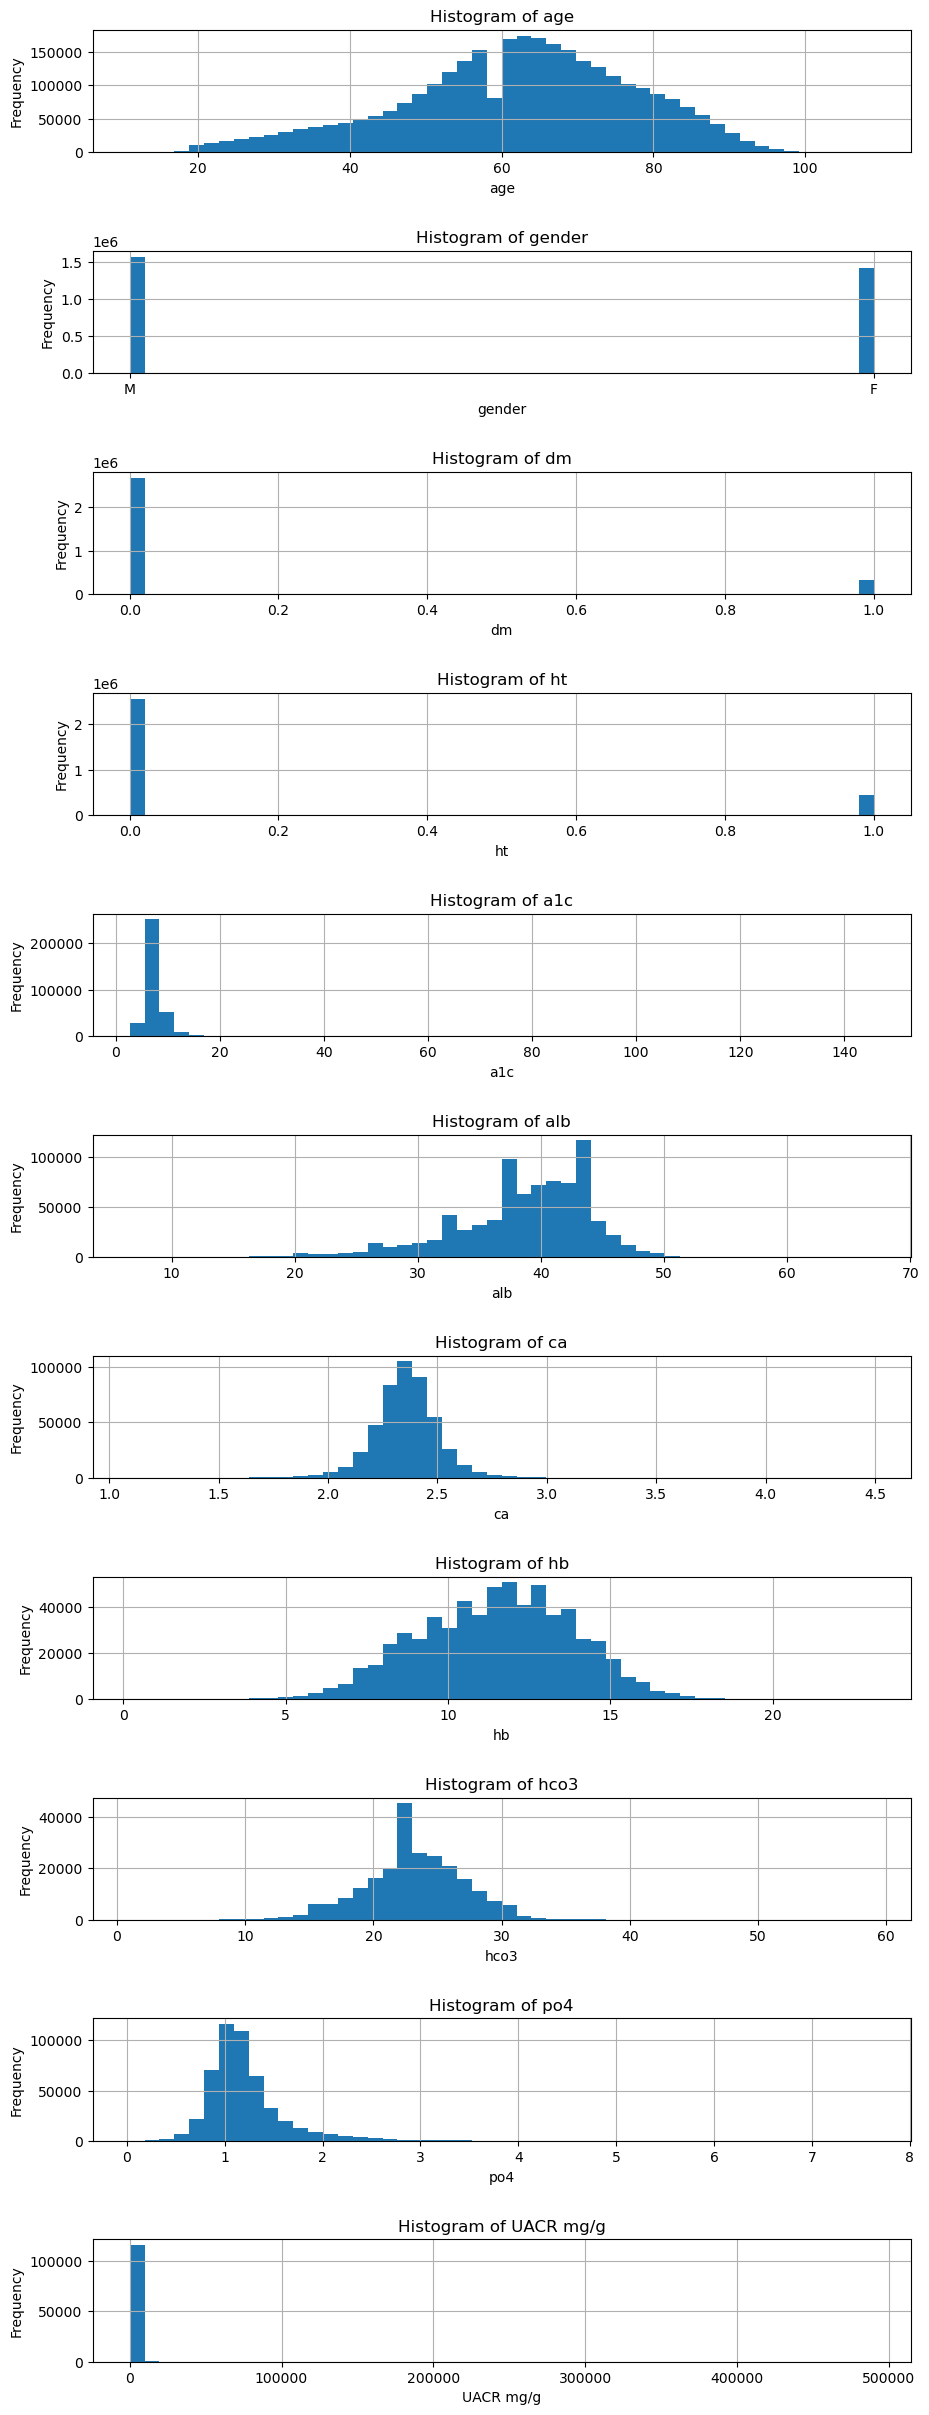

In [125]:
import matplotlib.pyplot as plt

# Select the columns for plotting histograms
columns_to_plot = ['age', 'gender', 'dm', 'ht', 'a1c', 'alb', 'ca', 'hb', 'hco3', 'po4', 'UACR mg/g']

# Plotting histograms for each selected column
fig, axes = plt.subplots(nrows=len(columns_to_plot), ncols=1, figsize=(10, 25))
fig.tight_layout(pad=5.0)

for i, column in enumerate(columns_to_plot):
    combined_df[column].hist(ax=axes[i], bins=50)
    axes[i].set_title(f'Histogram of {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frequency')

plt.show()


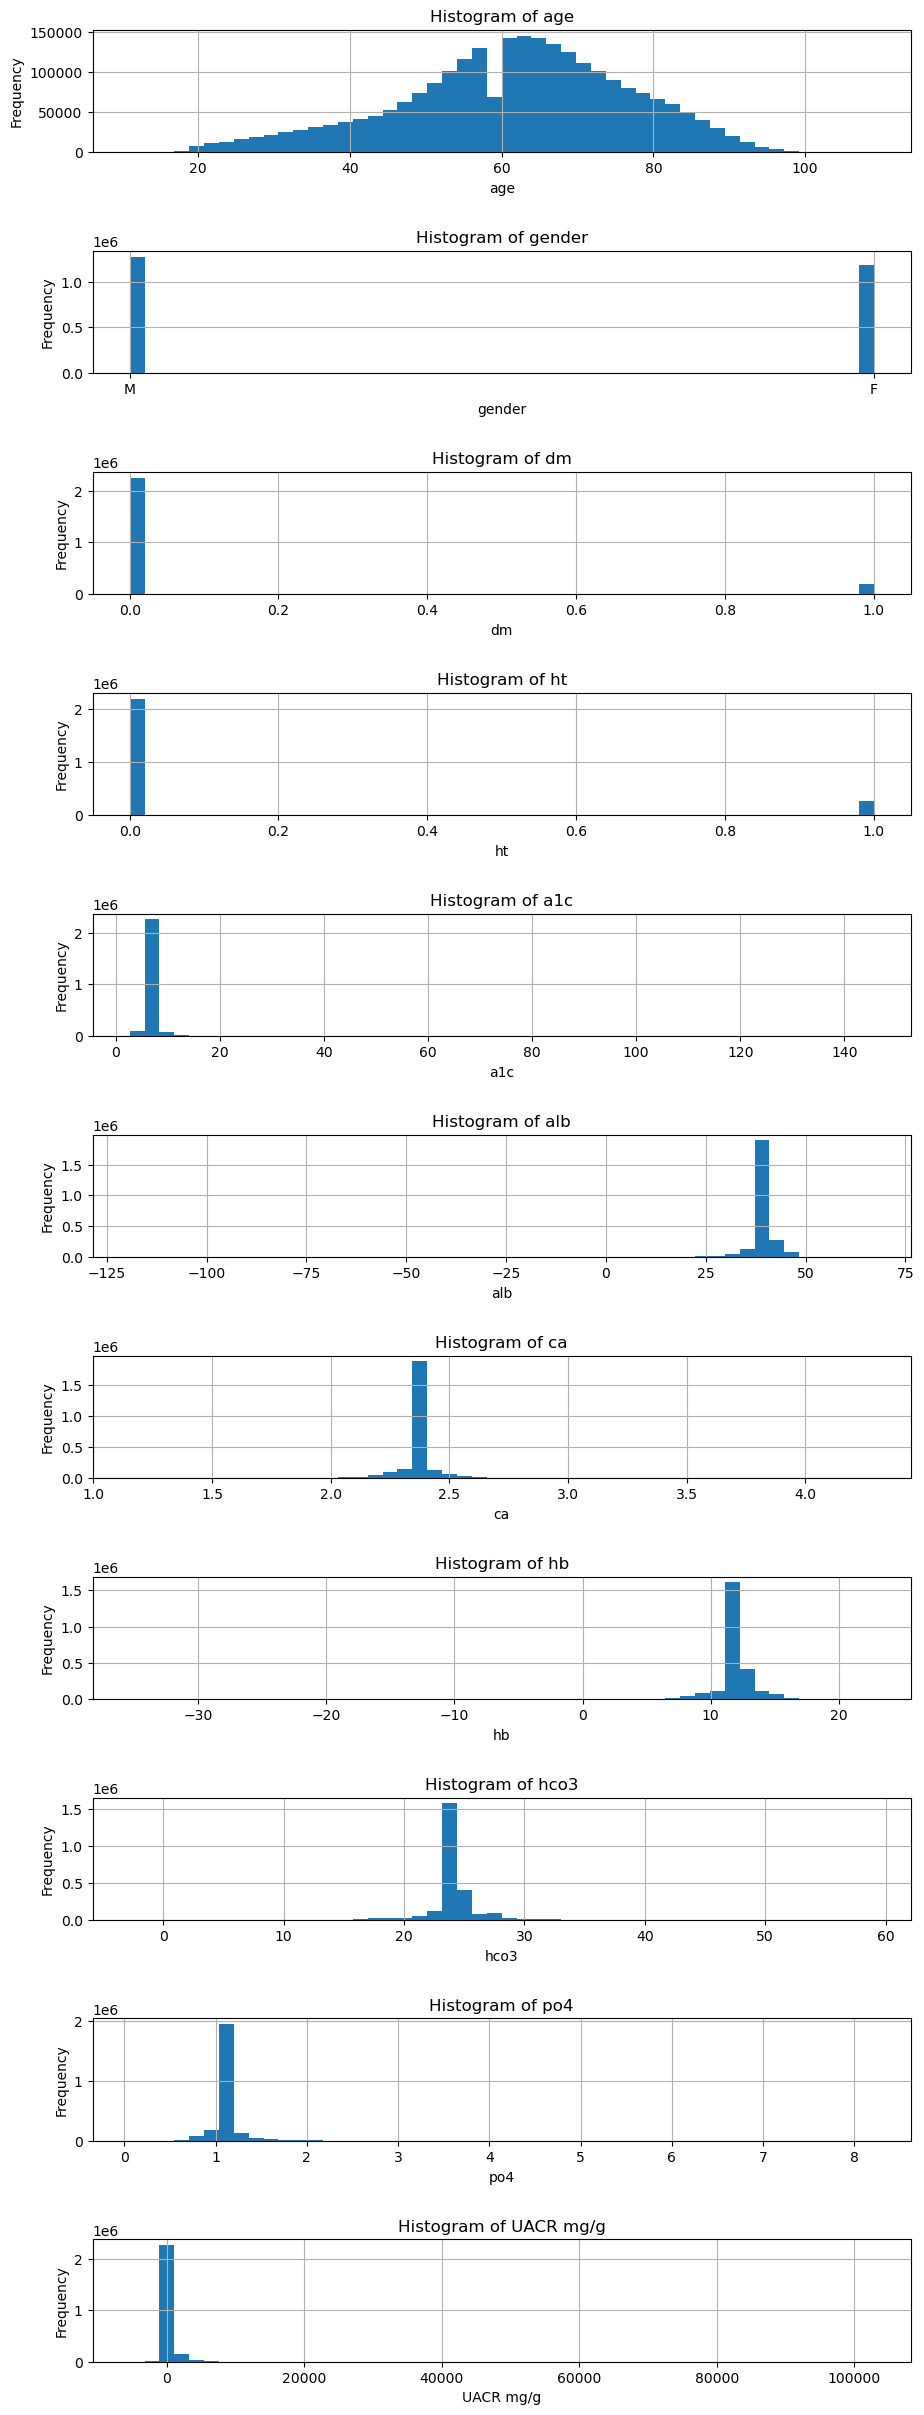

In [114]:
import matplotlib.pyplot as plt

# Select the columns for plotting histograms
columns_to_plot = ['age', 'gender', 'dm', 'ht', 'a1c', 'alb', 'ca', 'hb', 'hco3', 'po4', 'UACR mg/g']

# Plotting histograms for each selected column
fig, axes = plt.subplots(nrows=len(columns_to_plot), ncols=1, figsize=(10, 25))
fig.tight_layout(pad=5.0)

for i, column in enumerate(columns_to_plot):
    master_df[column].hist(ax=axes[i], bins=50)
    axes[i].set_title(f'Histogram of {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frequency')

plt.show()

In [115]:
master_df.isna().sum()

key                              0
date                             0
code                             0
Cr                               0
dob                              0
gender                           0
age                              0
first_diabetes_date        2142427
dm                               0
first_hypertension_date    2037529
ht                               0
prediction_point                 0
a1c                              0
alb                              0
ca                               0
hb                               0
hco3                             0
po4                              0
UACR mg/g                        0
dtype: int64

In [116]:
master_df

,key,date,code,Cr,dob,gender,age,first_diabetes_date,dm,first_hypertension_date,ht,prediction_point,a1c,alb,ca,hb,hco3,po4,UACR mg/g
0,449,2009-04-08 11:12:00,HN08019759M,125.0,1930-02-22,M,79.0,2009-09-10,0,2009-09-10,0,1.0,11.700000,28.000000,2.317900,10.200000,20.900000,1.040000,2972.057364
3,449,2009-06-22 09:56:00,HN09012526S,108.0,1930-02-22,M,79.0,2009-09-10,0,2009-09-10,0,1.0,11.700000,25.000000,2.317900,9.800000,20.900000,1.040000,3507.785951
4,449,2009-06-30 09:03:00,MG??0910744O,120.0,1930-02-22,M,79.0,2009-09-10,0,2009-09-10,0,1.0,13.600000,28.000000,2.317900,9.800000,20.900000,1.040000,3109.621016
5,449,2009-07-07 15:03:00,HN09013776M,116.0,1930-02-22,M,79.0,2009-09-10,0,2009-09-10,0,1.0,13.600000,26.000000,2.317900,8.900000,20.900000,1.040000,3495.797144
6,449,2009-07-08 11:04:00,HN090656875,129.0,1930-02-22,M,79.0,2009-09-10,0,2009-09-10,0,1.0,13.600000,28.000000,2.317900,8.900000,20.900000,1.040000,3150.865273
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3004415,13418573,2022-09-26 08:36:00,MG??22113863,45.0,1958-12-03,F,63.0,NaT,0,NaT,0,1.0,6.817332,40.745739,2.355220,12.378826,24.510399,1.092933,18.198000
3004416,13418573,2022-12-12 08:39:00,MG??22113863,39.0,1958-12-03,F,64.0,NaT,0,NaT,0,1.0,6.817332,40.745739,2.355220,12.378826,24.510399,1.092933,18.198000
3004417,13418573,2023-06-15 09:33:00,GOTS19217828,48.0,1958-12-03,F,64.0,NaT,0,NaT,0,1.0,6.817332,40.745739,2.355220,12.378826,24.510399,1.092933,18.198000
3004418,13470025,2023-04-09 20:16:00,HN230416286,55.0,1953-06-15,F,69.0,NaT,0,NaT,0,1.0,6.889539,39.777220,2.354819,12.090103,24.345251,1.136028,640.779495
